In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
import os

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import time

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
class DigitsDataset1(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        # df = pd.read_csv(self.csv_file)
        # df = df.loc[df.iloc[:, -1] == label]

        images = []
        for filename in os.listdir('./data/img/16000_samples/'):
            f = os.path.join('./data/img/16000_samples/', filename)
            if os.path.isfile(f):
                #print(size_test)
                images.append(np.load(f,allow_pickle=True).flatten()[:size_test])
                #print(len(images[-1]))
        df = pd.DataFrame(images)
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :]/2
        image = np.array(image)
        #print(len(image))
        image = image.astype(np.float32).reshape(size_test_square, size_test_square)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

In [3]:
size_test = 1025
size_test_square = int(np.sqrt(size_test-1))

In [4]:
size_test_square

32

In [5]:
np.sqrt(1024)

32.0

In [6]:
2**8

256

In [7]:
256*4

1024

In [28]:
image_size = size_test_square  # Height / width of the square images
batch_size = 2


transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset1(csv_file="./optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [29]:
dataset[2][0]

tensor([[[1.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.5000,  ..., 1.0000, 1.0000, 1.0000]]])

In [10]:
testing = np.load('./data/img/new/5_5_606_Facies.npy')

In [11]:
image_test = testing.astype(np.float32).reshape(size_test_square, size_test_square)

In [12]:
np.array(image_test )

array([[0., 0., 0., ..., 2., 0., 0.],
       [2., 2., 2., ..., 0., 0., 2.],
       [2., 2., 2., ..., 0., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

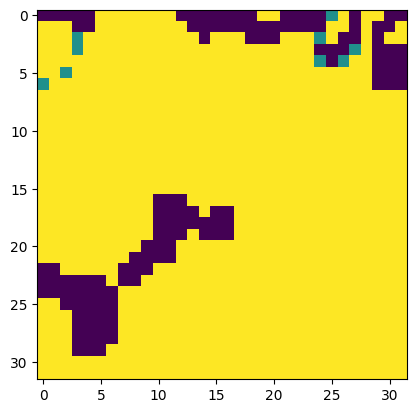

In [13]:
plt.imshow(np.array(image_test))

In [14]:
dataset[1][0]

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.5000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.5000],
         [0.0000, 0.5000, 1.0000,  ..., 1.0000, 0.0000, 1.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5000, 0.5000,  ..., 1.0000, 1.0000, 1.0000]]])

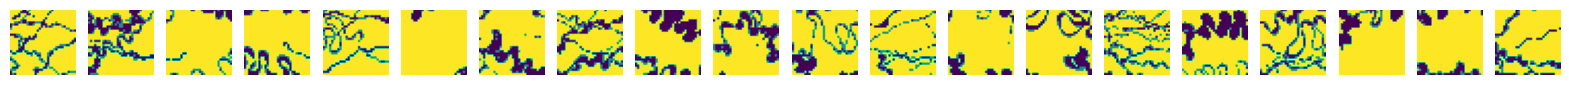

In [25]:
plt.figure(figsize=(20,22))

for i in range(20):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,20,i+1)
    plt.axis('off')
    plt.imshow(image.numpy()) #, cmap='gray'
    
plt.show()

In [16]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, size_test-1),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(size_test-1, 64),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [17]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

In [18]:
# Quantum variables
n_qubits = 9  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 5  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

In [19]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [21]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [26]:
lrG = 0.01  # Learning rate for the generator
lrD = 0.03  # Learning rate for the discriminator
num_iter = 300  # Number of training iterations

In [23]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(size_test_square , n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

t0 = time.time()
while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values         
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(image_size ,1,image_size,image_size).cpu().detach()
            
            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

t1 = time.time()
print(f'time:{t1-t0}')

Iteration: 10, Discriminator Loss: 0.866, Generator Loss: 0.679
Iteration: 20, Discriminator Loss: 0.631, Generator Loss: 0.838
Iteration: 30, Discriminator Loss: 0.541, Generator Loss: 0.956
Iteration: 40, Discriminator Loss: 0.428, Generator Loss: 1.112
Iteration: 50, Discriminator Loss: 0.327, Generator Loss: 1.334
Iteration: 60, Discriminator Loss: 0.268, Generator Loss: 1.563
Iteration: 70, Discriminator Loss: 0.178, Generator Loss: 1.988
Iteration: 80, Discriminator Loss: 0.162, Generator Loss: 1.971
Iteration: 90, Discriminator Loss: 0.111, Generator Loss: 2.330
Iteration: 100, Discriminator Loss: 0.149, Generator Loss: 2.158
Iteration: 110, Discriminator Loss: 0.087, Generator Loss: 2.599
Iteration: 120, Discriminator Loss: 0.094, Generator Loss: 2.478
Iteration: 130, Discriminator Loss: 0.086, Generator Loss: 2.547
Iteration: 140, Discriminator Loss: 0.069, Generator Loss: 2.777
Iteration: 150, Discriminator Loss: 0.056, Generator Loss: 2.957
Iteration: 160, Discriminator Loss

In [25]:
1120/60

18.666666666666668

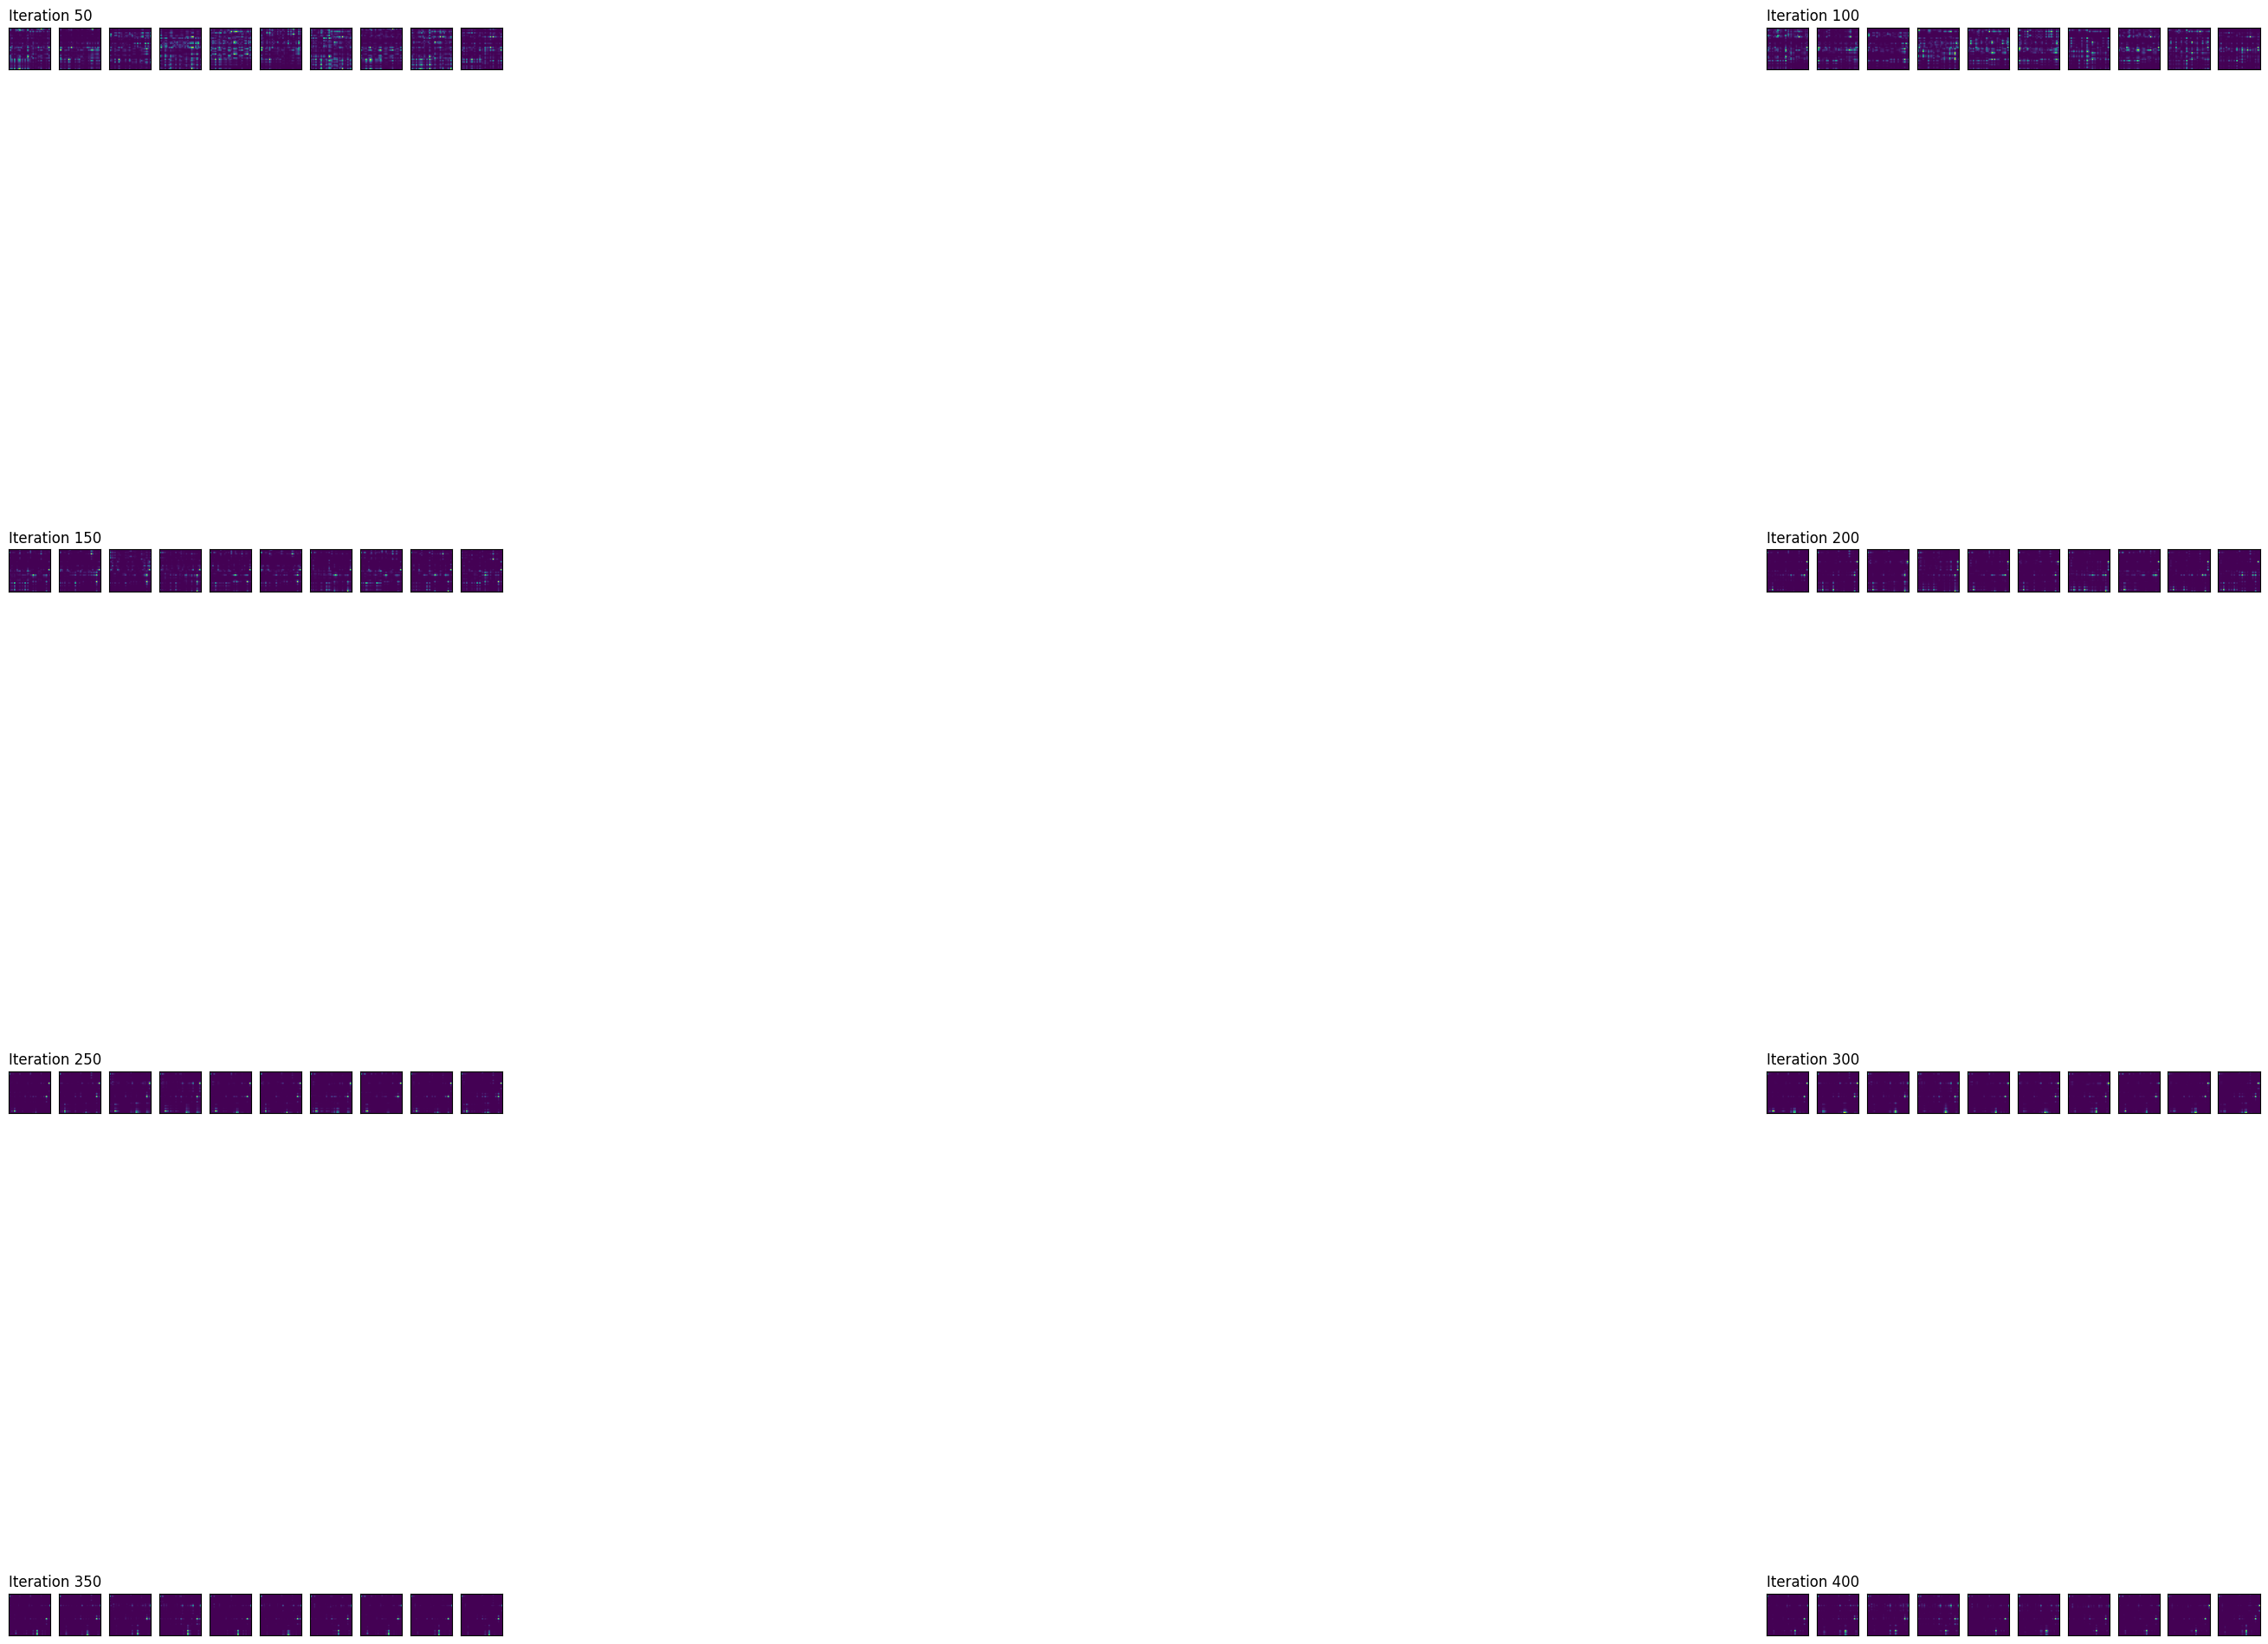

In [24]:
fig = plt.figure(figsize=(50, 30))
outer = gridspec.GridSpec(4, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])
    
    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):
        
        if j == 10:
            break
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy()) #, cmap="gray"
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)
        

plt.savefig('tesitng.png', dpi = 250)
plt.show()

In [60]:
dataset[1][0]

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.5000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.5000],
         [0.0000, 0.5000, 1.0000,  ..., 1.0000, 0.0000, 1.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.0000, 0.5000, 0.5000,  ..., 1.0000, 1.0000, 1.0000]]])

In [69]:
np.array(images[0]).min()

6.542377e-09

In [66]:
images[0]

tensor([[6.2498e-05, 2.1599e-02, 2.7681e-03,  ..., 1.7813e-01, 1.2394e-02,
         7.1994e-03],
        [2.6856e-03, 3.3957e-01, 2.0656e-02,  ..., 1.1802e-01, 1.2817e-02,
         1.2841e-02],
        [8.1639e-03, 1.3783e-02, 5.8800e-02,  ..., 8.0259e-02, 2.0753e-01,
         1.9936e-03],
        ...,
        [2.3935e-03, 4.0380e-03, 2.6871e-03,  ..., 1.1676e-02, 5.5477e-03,
         1.3463e-02],
        [3.9238e-03, 1.3669e-03, 2.6111e-04,  ..., 3.0868e-03, 4.2952e-03,
         1.7227e-02],
        [2.9982e-04, 1.3115e-03, 6.8787e-04,  ..., 4.3835e-03, 2.5113e-03,
         3.1335e-03]])

In [27]:
plt.figure(figsize=(20,22))

for i in range(20):
    image = images[i][0].reshape(image_size,image_size)
    plt.subplot(1,20,i+1)
    plt.axis('off')
    plt.imshow(image.numpy()) #, cmap='gray'
    
plt.show()

RuntimeError: shape '[32, 32]' is invalid for input of size 32

<Figure size 2000x2200 with 0 Axes>